## Problem Statement

We have been given a PDE: du/dx=2du/dt+u
and boundary condition: u(x,0)=6e^(-3x)

- Independent variables: x,t (input)
- Dependent variables: u (outputs)


We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]


When we solved this problem analytically, we found the solution: u(x,t) = 6e^(-3x-2t)


Our f is f = du/dx - 2du/dt - u

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In ur case: #inputs = 2 (x,t)
and #outputs = 1

You can add ass many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
min 5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [3]:
### (2) Model
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    return pde

In [5]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)

In [7]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(3.3227)
1 Traning Loss: tensor(3.3113)
2 Traning Loss: tensor(3.3000)
3 Traning Loss: tensor(3.2888)
4 Traning Loss: tensor(3.2776)
5 Traning Loss: tensor(3.2665)
6 Traning Loss: tensor(3.2556)
7 Traning Loss: tensor(3.2447)
8 Traning Loss: tensor(3.2339)
9 Traning Loss: tensor(3.2231)
10 Traning Loss: tensor(3.2125)
11 Traning Loss: tensor(3.2020)
12 Traning Loss: tensor(3.1915)
13 Traning Loss: tensor(3.1812)
14 Traning Loss: tensor(3.1709)
15 Traning Loss: tensor(3.1607)
16 Traning Loss: tensor(3.1506)
17 Traning Loss: tensor(3.1407)
18 Traning Loss: tensor(3.1308)
19 Traning Loss: tensor(3.1210)
20 Traning Loss: tensor(3.1113)
21 Traning Loss: tensor(3.1017)
22 Traning Loss: tensor(3.0922)
23 Traning Loss: tensor(3.0828)
24 Traning Loss: tensor(3.0735)
25 Traning Loss: tensor(3.0643)
26 Traning Loss: tensor(3.0552)
27 Traning Loss: tensor(3.0462)
28 Traning Loss: tensor(3.0373)
29 Traning Loss: tensor(3.0285)
30 Traning Loss: tensor(3.0198)
31 Traning Loss: t

C:\Users\DaeilLee\AppData\Local\Temp\ipykernel_4664\883633278.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


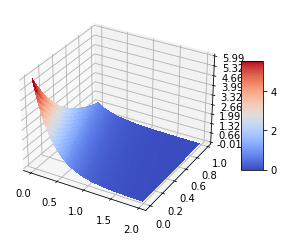

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()